In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 96% 1.28G/1.33G [00:07<00:00, 141MB/s]
100% 1.33G/1.33G [00:07<00:00, 189MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/celeba-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.layers import Input

discriminator=Sequential()
discriminator.add(Input(shape=(64,64,3)))
discriminator.add(Conv2D(64,(4,4),strides=(2,2),padding="same"))
discriminator.add(LeakyReLU(negative_slope=0.2))

discriminator.add(Conv2D(128,(4,4),strides=(2,2),padding="same"))
discriminator.add(LeakyReLU(negative_slope=0.2))

discriminator.add(Conv2D(128,(4,4),strides=(2,2),padding="same"))
discriminator.add(LeakyReLU(negative_slope=0.2))

discriminator.add(Flatten())
discriminator.add(Dropout(0.2))
discriminator.add(Dense(1,activation="sigmoid"))
discriminator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.layers import Input

latent_dim=100
generator=Sequential()
generator.add(Input(shape=(latent_dim,)))
generator.add(Dense(8*8*128))
generator.add(LeakyReLU(negative_slope=0.2))
generator.add(Reshape((8,8,128)))

generator.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding="same"))
generator.add(LeakyReLU(negative_slope=0.2))

generator.add(Conv2DTranspose(256,(4,4),strides=(2,2),padding="same"))
generator.add(LeakyReLU(negative_slope=0.2))

generator.add(Conv2DTranspose(512,(4,4),strides=(2,2),padding="same"))
generator.add(LeakyReLU(negative_slope=0.2))

generator.add(Conv2D(3,(5,5),activation="sigmoid",padding="same"))

generator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │       827,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,750,275 (14.31 MB)

 Trainable params: 3,750,275 (14.31 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow import keras
dataset=keras.preprocessing.image_dataset_from_directory(
    directory="/content/img_align_celeba",
    label_mode=None,
    image_size=(64,64),
    batch_size=32,
    shuffle=True
)
def scale_images(image_batch):
    return tf.cast(image_batch, tf.float32) / 255.0

dataset = dataset.map(scale_images)


Found 202599 files.


In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array  # <-- fixed import

class GAN(keras.Model):
  def __init__(self,discriminator,generator,latent_dim):
    super(GAN,self).__init__()
    self.discriminator=discriminator
    self.generator=generator
    self.latent_dim=latent_dim

  def compile(self,d_optimizer,g_optimizer,loss_fn):
    super(GAN,self).compile()
    self.d_optimizer=d_optimizer
    self.g_optimizer=g_optimizer
    self.loss_fn=loss_fn
    self.d_loss_metric=keras.metrics.Mean(name="d_loss")
    self.g_loss_metric=keras.metrics.Mean(name="g_loss")

  @property
  def metrics(self):
    return [self.d_loss_metric,self.g_loss_metric]

  def train_step(self,real_images):
    batch_size=tf.shape(real_images)[0]
    random_latent_vectors=tf.random.normal(shape=(batch_size,self.latent_dim))
    generated_images=self.generator(random_latent_vectors)
    combined_images=tf.concat([generated_images,real_images],axis=0)
    labels=tf.concat([tf.ones((batch_size,1)),tf.zeros((batch_size,1))],axis=0)
    labels+=0.05*tf.random.uniform(tf.shape(labels))

    with tf.GradientTape() as tape:
      predictions=self.discriminator(combined_images)
      d_loss=self.loss_fn(labels,predictions)
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

    random_latent_vectors=tf.random.normal(shape=(batch_size,self.latent_dim))
    misleading_labels=tf.zeros((batch_size,1))

    with tf.GradientTape() as tape:
      predictions=self.discriminator(self.generator(random_latent_vectors))
      g_loss=self.loss_fn(misleading_labels,predictions)
    grads=tape.gradient(g_loss,self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads,self.generator.trainable_weights))

    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)
    return {
        "d_loss":self.d_loss_metric.result(),
        "g_loss":self.g_loss_metric.result()
    }


In [ ]:
from tensorflow.keras.utils import save_img

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=5, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images + 1) / 2.0  # scale to [0,1]

        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            save_img(f"generated_img{epoch:03d}_{i}.png", img)  # <-- fixed
            plt.imshow(img)
            plt.axis("off")
            plt.show()


Epoch 1/5
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - d_loss: 0.4833 - g_loss: 4.2826

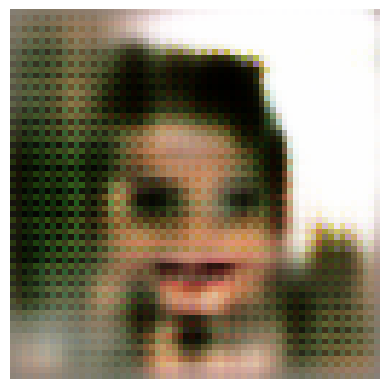

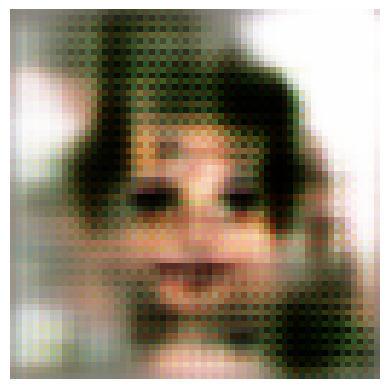

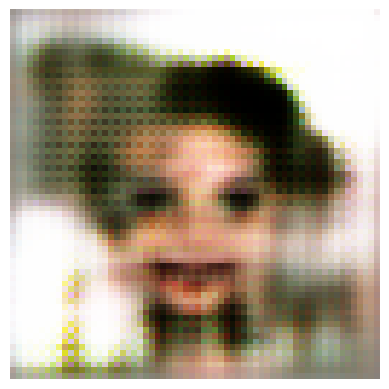

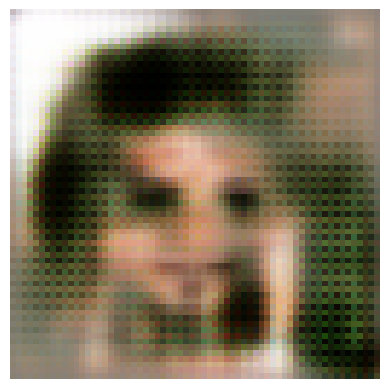

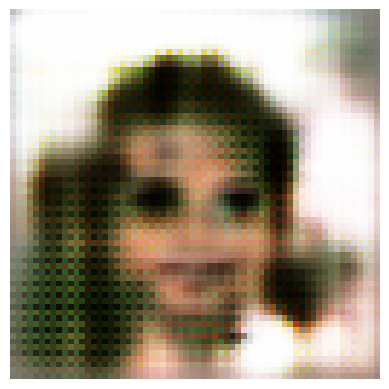

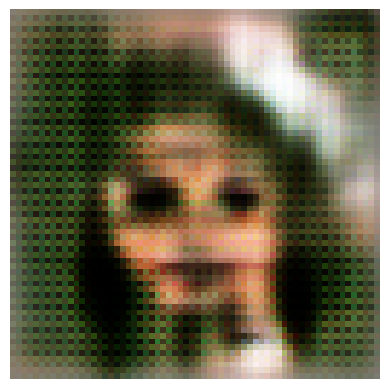

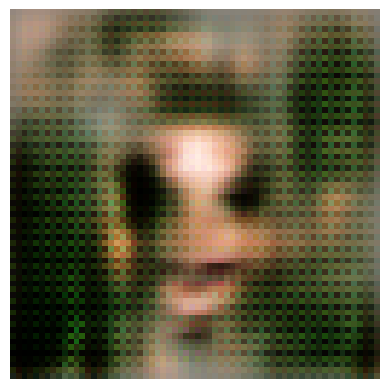

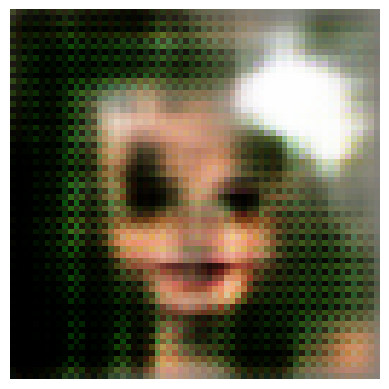

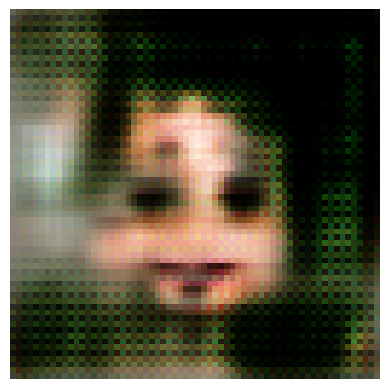

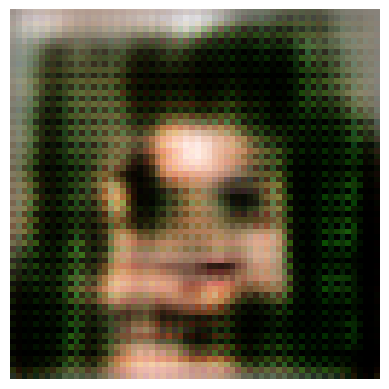

6332/6332 ━━━━━━━━━━━━━━━━━━━━ 1798s 281ms/step - d_loss: 0.4833 - g_loss: 4.2823
Epoch 2/5
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - d_loss: 0.5988 - g_loss: 1.1687

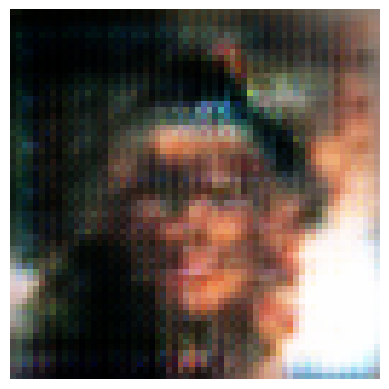

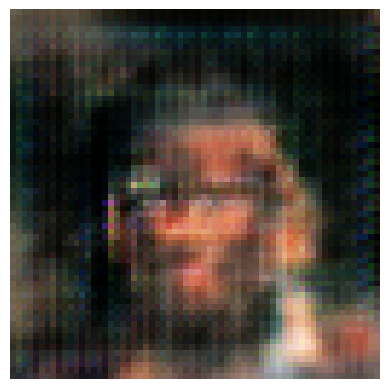

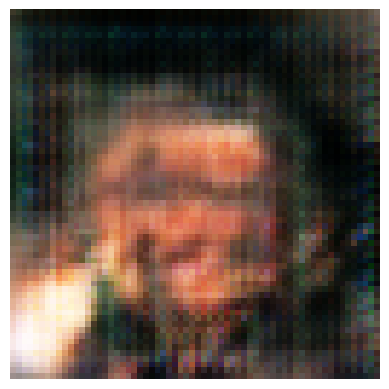

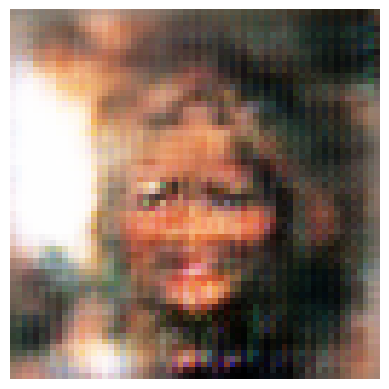

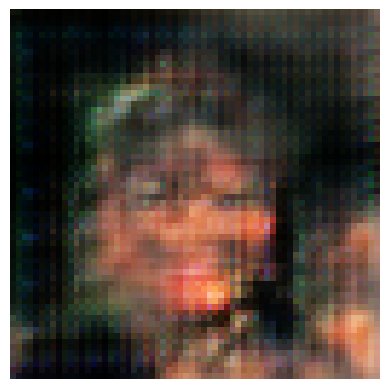

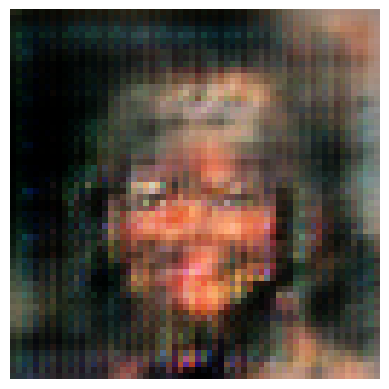

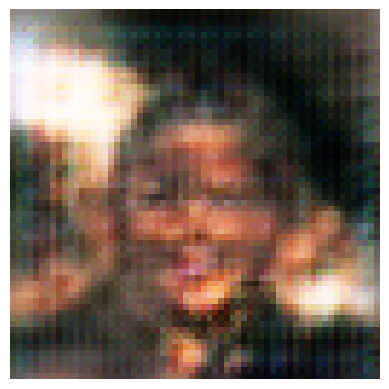

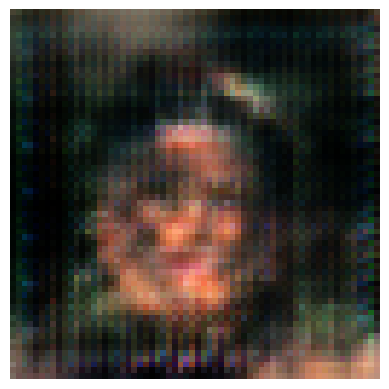

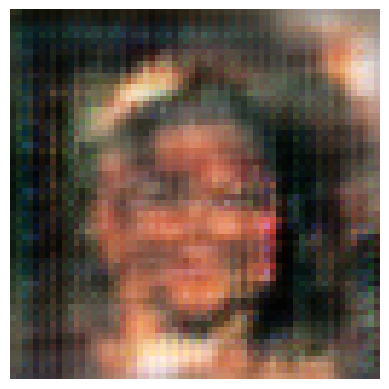

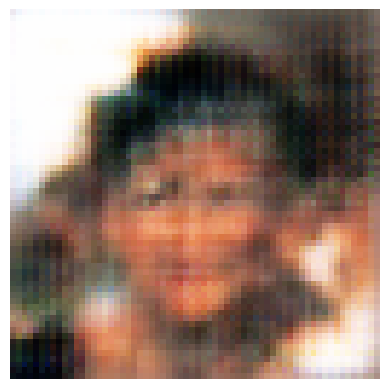

6332/6332 ━━━━━━━━━━━━━━━━━━━━ 1804s 281ms/step - d_loss: 0.5988 - g_loss: 1.1687
Epoch 3/5
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - d_loss: 0.6061 - g_loss: 1.2157

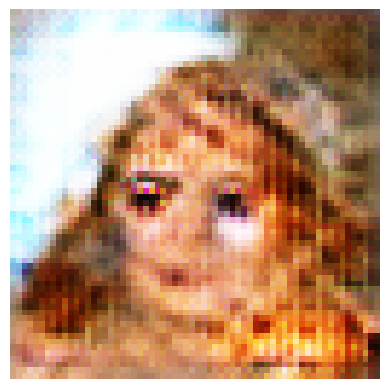

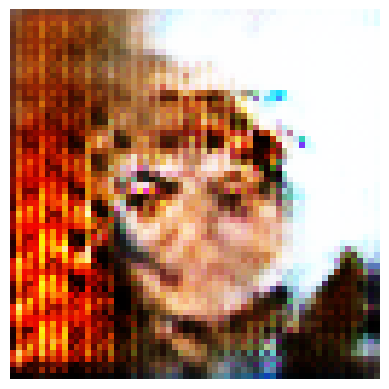

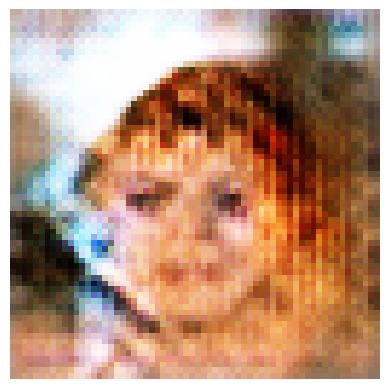

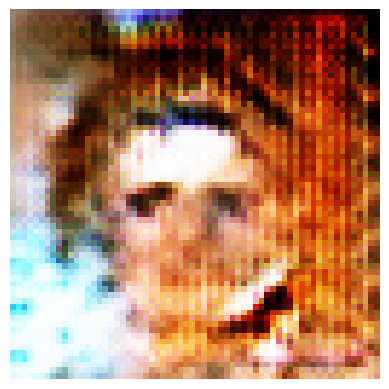

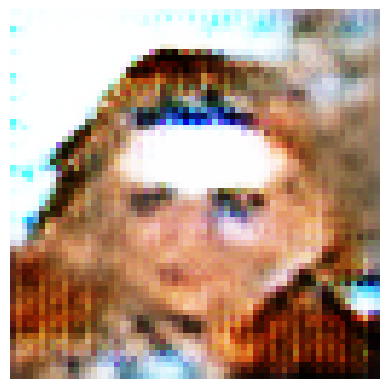

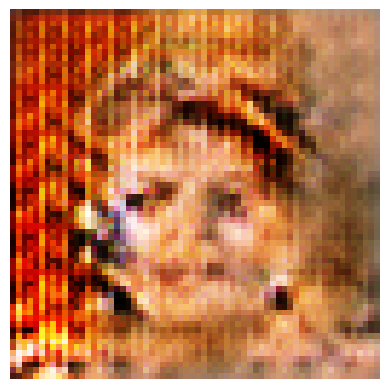

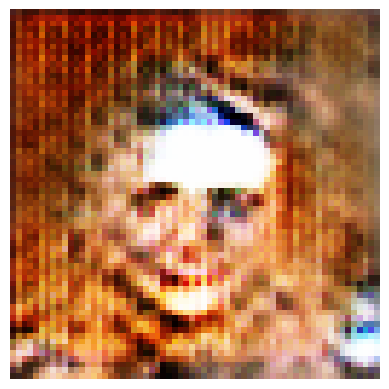

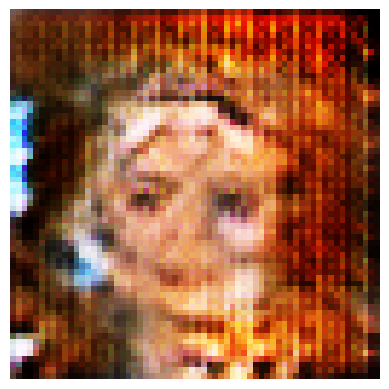

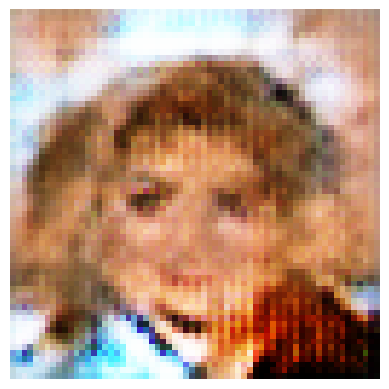

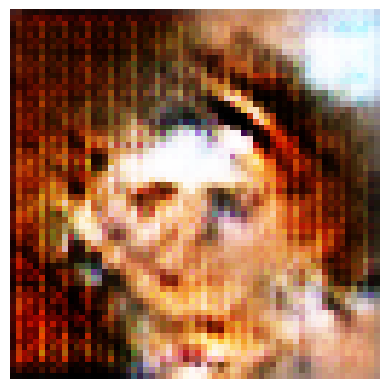

6332/6332 ━━━━━━━━━━━━━━━━━━━━ 1780s 281ms/step - d_loss: 0.6061 - g_loss: 1.2157
Epoch 4/5
4161/6332 ━━━━━━━━━━━━━━━━━━━━ 10:10 281ms/step - d_loss: 0.5930 - g_loss: 1.2340

In [ ]:
epochs=5
gan=GAN(discriminator=discriminator,generator=generator,latent_dim=latent_dim)
gan.compile(d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss_fn=keras.losses.BinaryCrossentropy())
gan.fit(dataset,epochs=epochs,callbacks=[GANMonitor(num_img=10,latent_dim=latent_dim)])

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Folder to save checkpoints
checkpoint_dir = '/content/drive/MyDrive/GAN_checkpoints/'

# Create checkpoint object for your GAN
checkpoint = tf.train.Checkpoint(
    generator=generator,
    discriminator=discriminator,
    g_optimizer=generator_optimizer,
    d_optimizer=discriminator_optimizer
)

# Optional: Use CheckpointManager to keep only last 5 checkpoints
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

# Save a checkpoint (call this after each epoch or whenever you want)
save_path = manager.save()
print(f"Checkpoint saved at: {save_path}")


In [ ]:
# Mount Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

# Checkpoint directory
checkpoint_dir = '/content/drive/MyDrive/GAN_checkpoints/'

# Recreate checkpoint object
checkpoint = tf.train.Checkpoint(
    generator=generator,
    discriminator=discriminator,
    g_optimizer=generator_optimizer,
    d_optimizer=discriminator_optimizer
)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

# Restore latest checkpoint
if manager.latest_checkpoint:
    checkpoint.restore(manager.latest_checkpoint)
    print("Checkpoint restored from:", manager.latest_checkpoint)
else:
    print("No checkpoint found. Starting from scratch.")

# Optional: parse last epoch number from checkpoint filename if needed
start_epoch = int(manager.latest_checkpoint.split('-')[-1]) if manager.latest_checkpoint else 0

# Example: Resume training loop
for epoch in range(start_epoch, total_epochs):
    for batch in dataset:  # your dataset iterator
        gan.train_step(batch)

    # Save checkpoint after each epoch
    save_path = manager.save()
    print(f"Epoch {epoch+1} checkpoint saved at: {save_path}")


In [ ]:
from tensorflow.keras.utils import save_img
import matplotlib.pyplot as plt
import tensorflow as tf
import os

class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=5, latent_dim=100, save_every=6, save_dir="generated"):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.save_every = save_every
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        # --- Generate images ---
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images + 1) / 2.0  # scale to [0,1]

        # --- Save images ---
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            save_img(os.path.join(self.save_dir, f"generated_img{epoch:03d}_{i}.png"), img)
            plt.imshow(img)
            plt.axis("off")
            plt.show()

        # --- Save generator model every `save_every` epochs ---
        if (epoch + 1) % self.save_every == 0:
            model_path = os.path.join(self.save_dir, f"generator_epoch_{epoch+1}.h5")
            self.model.generator.save(model_path)
            print(f"Saved generator model at epoch {epoch+1} -> {model_path}")


In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array  # <-- fixed import

class GAN(keras.Model):
  def __init__(self,discriminator,generator,latent_dim):
    super(GAN,self).__init__()
    self.discriminator=discriminator
    self.generator=generator
    self.latent_dim=latent_dim

  def compile(self,d_optimizer,g_optimizer,loss_fn):
    super(GAN,self).compile()
    self.d_optimizer=d_optimizer
    self.g_optimizer=g_optimizer
    self.loss_fn=loss_fn
    self.d_loss_metric=keras.metrics.Mean(name="d_loss")
    self.g_loss_metric=keras.metrics.Mean(name="g_loss")

  @property
  def metrics(self):
    return [self.d_loss_metric,self.g_loss_metric]

  def train_step(self,real_images):
    batch_size=tf.shape(real_images)[0]
    random_latent_vectors=tf.random.normal(shape=(batch_size,self.latent_dim))
    generated_images=self.generator(random_latent_vectors)
    combined_images=tf.concat([generated_images,real_images],axis=0)
    labels=tf.concat([tf.ones((batch_size,1)),tf.zeros((batch_size,1))],axis=0)
    labels+=0.05*tf.random.uniform(tf.shape(labels))

    with tf.GradientTape() as tape:
      predictions=self.discriminator(combined_images)
      d_loss=self.loss_fn(labels,predictions)
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

    random_latent_vectors=tf.random.normal(shape=(batch_size,self.latent_dim))
    misleading_labels=tf.zeros((batch_size,1))

    with tf.GradientTape() as tape:
      predictions=self.discriminator(self.generator(random_latent_vectors))
      g_loss=self.loss_fn(misleading_labels,predictions)
    grads=tape.gradient(g_loss,self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads,self.generator.trainable_weights))

    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)
    return {
        "d_loss":self.d_loss_metric.result(),
        "g_loss":self.g_loss_metric.result()
    }


In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # Mount your Account A's drive

